In [116]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [203]:
def read_image(path):
    """Read image and output RGB image (0-1).

    Args:
        path (str): path to file

    Returns:
        array: RGB image (0-1)
    """
    img = cv2.imread(path)

    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    return img

def load_sparse_depth(input_sparse_depth_fp):
    input_sparse_depth = np.array(Image.open(input_sparse_depth_fp), dtype=np.float32) / 256.0
    input_sparse_depth[input_sparse_depth <= 0] = 0.0
    return input_sparse_depth

def load_image(path, normalize=False, data_format='HWC'):
    '''
    Loads an RGB image

    Arg(s):
        path : str
            path to RGB image
        normalize : bool
            if set, then normalize image between [0, 1]
        data_format : str
            'CHW', or 'HWC'
    Returns:
        numpy[float32] : H x W x C or C x H x W image
    '''

    # Load image
    image = Image.open(path).convert('RGB')

    # Convert to numpy
    image = np.asarray(image, np.float32)/255

    if data_format == 'HWC':
        pass
    elif data_format == 'CHW':
        image = np.transpose(image, (2, 0, 1))
    else:
        raise ValueError('Unsupported data format: {}'.format(data_format))

    # Normalize
    #image = image / 255.0 if normalize else image #255.0

    return image
def load_depth(path, multiplier=256.0, data_format='HW'):
    '''
    Loads a depth map from a 16-bit PNG file

    Arg(s):
        path : str
            path to 16-bit PNG file
        multiplier : float
            multiplier for encoding float as 16/32 bit unsigned integer
        data_format : str
            HW, CHW, HWC
    Returns:
        numpy[float32] : depth map
    '''

    # Loads depth map from 16-bit PNG file
    z = np.array(Image.open(path), dtype=np.float32)

    # Assert 16-bit (not 8-bit) depth map
    z = z / multiplier # A scaling factor used to convert the 16-bit unsigned integer values stored in the PNG file back into floating-point depth values (typically in meters).
    z[z <= 0] = 0.0

    if data_format == 'HW':
        pass
    elif data_format == 'CHW':
        z = np.expand_dims(z, axis=0)
    elif data_format == 'HWC':
        z = np.expand_dims(z, axis=-1)
    else:
        raise ValueError('Unsupported data format: {}'.format(data_format))

    return z

In [204]:
import torch.utils
import torch.utils.data
import torch.utils.data.dataset
import random


class RCNetTrainingDataset(torch.utils.data.Dataset):
    '''
    Dataset for fetching:
        (1) image
        (2) radar point
        (3) ground truth
        (4) bounding boxes for the points
        (5) image crops for summary part of the code

    Arg(s):
        image_paths : list[str]
            paths to images
        radar_paths : list[str]
            paths to radar points
        ground_truth_paths : list[str]
            paths to ground truth depth maps
        crop_width : int
            width of crop centered at the radar point
        total_points_sampled: int
            total number of points sampled from the total radar points available. Repeats the same points multiple times if total points in the frame is less than total sampled points
        sample_probability_of_lidar: int
            randomly sample lidar with this probability and add noise to it instead of using radar points
    '''

    def __init__(self,
                 image_paths,
                 radar_paths,
                 ground_truth_paths,
                 patch_size,
                 total_points_sampled,
                 sample_probability_of_lidar):

        self.n_sample = len(image_paths)

        assert self.n_sample == len(ground_truth_paths)
        assert self.n_sample == len(radar_paths)

        self.image_paths = image_paths
        self.radar_paths = radar_paths
        self.ground_truth_paths = ground_truth_paths

        self.patch_size = patch_size
        self.pad_size_x = patch_size[1] // 2
        self.padding = ((0, 0), (0, 0), (self.pad_size_x, self.pad_size_x))

        self.data_format = 'CHW'
        self.total_points_sampled = total_points_sampled
        self.sample_probability_of_lidar = sample_probability_of_lidar

    def __getitem__(self, index):

        # Load image
        image = load_image(
            self.image_paths[index],
            normalize=False,
           data_format=self.data_format)

        height, width = image.shape[1:]
        if height == 720: # ZJU dataset
            image = image[:, 720 // 3: 720 // 4 * 3, :]

        image = np.pad(
            image,
            pad_width=self.padding,
            mode='edge')

        # Load radar points N x 3
        radar_points = np.load(self.radar_paths[index])

        if height == 720:
            radar_points = radar_points[radar_points[:, 1] < 720 // 4 * 3]
            radar_points[:, 1] = radar_points[:, 1] - 720 // 3
            radar_points = radar_points[radar_points[:, 1] >= 0]

        if radar_points.ndim == 1:
            # Only one point (,3), expand to 1 x 3
            radar_points = np.expand_dims(radar_points, axis=0)

        # Store bounding boxes for all radar points
        bounding_boxes_list = []

        # randomly sample radar points to output
        if radar_points.shape[0] <= self.total_points_sampled:
            radar_points = np.repeat(radar_points, 100, axis=0)
        random_idx = np.random.randint(radar_points.shape[0], size=self.total_points_sampled)
        radar_points = radar_points[random_idx, :]

        # Load ground truth depth
        ground_truth = load_depth(
            self.ground_truth_paths[index],
            data_format=self.data_format)

        if height == 720:
            ground_truth = ground_truth[:, 720 // 3: 720 // 4 * 3]

        if random.random() < self.sample_probability_of_lidar:
            ground_truth_for_sampling = np.copy(ground_truth)
            ground_truth_for_sampling = ground_truth_for_sampling.squeeze()
            # Find lidar points with depth greater than 1
            idx_lidar_samples = np.where(ground_truth_for_sampling > 1)

            # randomly sample total_points_sampled number of points from the lidar
            random_indices = random.sample(range(0, len(idx_lidar_samples[0])), self.total_points_sampled)

            points_x = idx_lidar_samples[1][random_indices]
            points_y = idx_lidar_samples[0][random_indices]
            points_z = ground_truth_for_sampling[points_y, points_x]

            noise_for_fake_radar_x = np.random.normal(0, 25, radar_points.shape[0])
            noise_for_fake_radar_z = np.random.uniform(low=0.0, high=0.4, size=radar_points.shape[0])

            fake_radar_points = np.copy(radar_points)
            fake_radar_points[:, 0] = points_x + noise_for_fake_radar_x
            fake_radar_points[:, 0] = np.clip(fake_radar_points[:, 0], 0, ground_truth_for_sampling.shape[1])
            fake_radar_points[:, 2] = points_z + noise_for_fake_radar_z
            # we keep the y as the same it is since it is erroneous

            # convert x and y indices back to int after adding noise
            fake_radar_points[:, 0] = fake_radar_points[:, 0].astype(int)
            fake_radar_points[:, 1] = fake_radar_points[:, 1].astype(int)

            radar_points = np.copy(fake_radar_points)

        # get the shifted radar points after padding
        for radar_point_idx in range(0, radar_points.shape[0]):
            # Set radar point to the center of the patch
            radar_points[radar_point_idx, 0] = radar_points[radar_point_idx, 0] + self.pad_size_x

            bounding_box = [0, 0, 0, 0]
            bounding_box[0] = radar_points[radar_point_idx, 0] - self.pad_size_x
            bounding_box[1] = 0
            bounding_box[2] = radar_points[radar_point_idx, 0] + self.pad_size_x
            bounding_box[3] = self.patch_size[0]
            bounding_boxes_list.append(np.asarray(bounding_box))

        ground_truth = np.pad(
            ground_truth,
            pad_width=self.padding,
            mode='constant',
            constant_values=0)

        ground_truth_crops = []

        # Crop image and ground truth
        for radar_point_idx in range(0, radar_points.shape[0]):
            start_x = int(radar_points[radar_point_idx, 0] - self.pad_size_x)
            end_x = int(radar_points[radar_point_idx, 0] + self.pad_size_x)
            start_y = image.shape[-2] - self.patch_size[0]

            ground_truth_cropped = ground_truth[:, start_y:, start_x:end_x]
            ground_truth_crops.append(ground_truth_cropped)

        image = image[:, start_y:, ...]

        ground_truth = np.asarray(ground_truth_crops)

        # Convert to float32
        image, radar_points, ground_truth = [
            T.astype(np.float32)
            for T in [image, radar_points, ground_truth]
        ]

        bounding_boxes_list = [T.astype(np.float32) for T in bounding_boxes_list]

        bounding_boxes_list = np.stack(bounding_boxes_list, axis=0)

        return image, radar_points, bounding_boxes_list, ground_truth

    def __len__(self):
        return self.n_sample

        

In [205]:
import os
import glob
root = r'C:\Users\kagad\OneDrive\Desktop\RADAR_CAM'
image_path = os.path.join(root, 'data', 'image')
radar_path = os.path.join(root, 'data', 'radar')
gt_path = os.path.join(root, 'data', 'gt_interp')
train_list = os.path.join(root, 'data', 'train.txt')

In [206]:

path = {"image_paths":[os.path.join(image_path,x) for x in os.listdir(image_path)],"radar_path":[os.path.join(radar_path,x) for x in os.listdir(radar_path)],"gt_path":[os.path.join(gt_path,x) for x in os.listdir(gt_path)]}

In [207]:
img = cv2.imread(path["image_paths"][0])


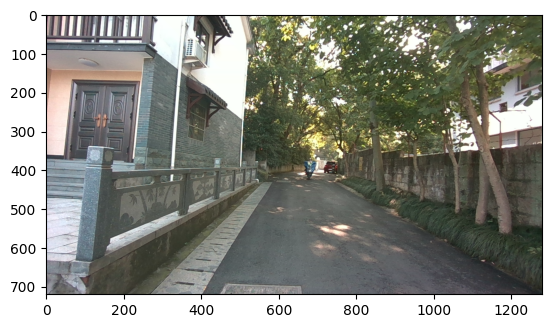

In [208]:
img = load_image(path["image_paths"][0])
plt.imshow(img)

In [209]:
train_dataloader = torch.utils.data.DataLoader(
        RCNetTrainingDataset(
            image_paths=path["image_paths"][:-1],
            radar_paths=path["radar_path"],
            ground_truth_paths=path["gt_path"],
            patch_size=[300,100],
            total_points_sampled=40,
            sample_probability_of_lidar=0.10),
        batch_size=1,
        shuffle=True,
        num_workers=0)

In [224]:
image, radar_points, bounding_boxes_list, ground_truth = next(iter(train_dataloader))

In [229]:
ground_truth.squeeze(0)[0]

tensor([[[12.6602, 12.7422, 12.8164,  ..., 16.5742, 16.6758, 16.8125],
         [12.6719, 12.7500, 12.8203,  ..., 16.5586, 16.6797, 16.8164],
         [12.6836, 12.7539, 12.8242,  ..., 16.5430, 16.6836, 16.8203],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [228]:
bounding_boxes_list

tensor([[[ 545.,    0.,  645.,  300.],
         [ 545.,    0.,  645.,  300.],
         [ 816.,    0.,  916.,  300.],
         [ 536.,    0.,  636.,  300.],
         [ 635.,    0.,  735.,  300.],
         [ 548.,    0.,  648.,  300.],
         [ 617.,    0.,  717.,  300.],
         [ 806.,    0.,  906.,  300.],
         [ 837.,    0.,  937.,  300.],
         [ 639.,    0.,  739.,  300.],
         [ 553.,    0.,  653.,  300.],
         [ 806.,    0.,  906.,  300.],
         [ 578.,    0.,  678.,  300.],
         [ 883.,    0.,  983.,  300.],
         [ 515.,    0.,  615.,  300.],
         [ 837.,    0.,  937.,  300.],
         [ 545.,    0.,  645.,  300.],
         [ 570.,    0.,  670.,  300.],
         [ 611.,    0.,  711.,  300.],
         [ 253.,    0.,  353.,  300.],
         [ 736.,    0.,  836.,  300.],
         [ 532.,    0.,  632.,  300.],
         [ 545.,    0.,  645.,  300.],
         [ 445.,    0.,  545.,  300.],
         [ 445.,    0.,  545.,  300.],
         [ 515.,    0.,  

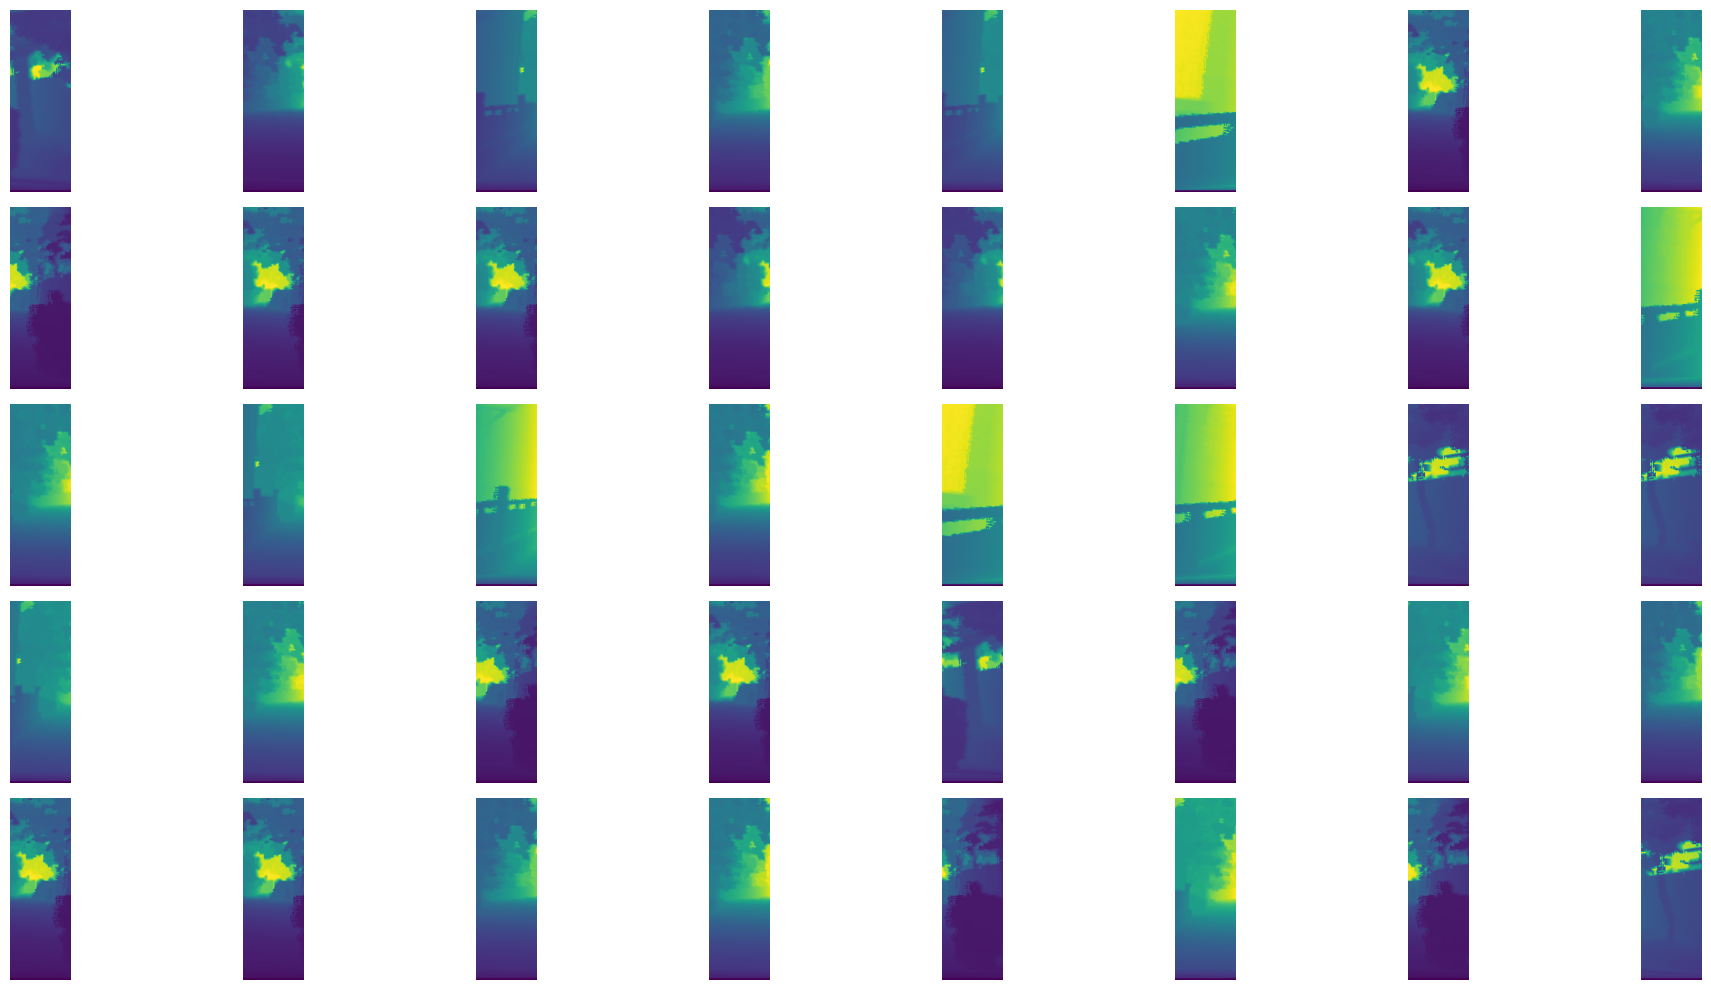

In [221]:
import matplotlib.pyplot as plt

# Assuming `ground_truth` is a tensor with shape (40, C, H, W)

# Number of images to plot
num_images = 40

# Number of rows and columns in the grid
n_rows = 5
n_cols = 8

# Create a figure with a specific size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))

# Iterate through the grid and plot each image
for i in range(num_images):
    # Calculate row and column index
    row = i // n_cols
    col = i % n_cols
    
    # Select the specific subplot axis
    ax = axes[row, col]
    
    # Get the ith ground truth image, squeeze and permute it to (H, W, C)
    img = ground_truth.squeeze(0)[i].permute(1, 2, 0)
    
    # Plot the image
    ax.imshow(img)
    ax.axis('off')  # Optionally turn off axis labels

# Adjust layout
plt.tight_layout()
plt.show()


In [183]:
image.shape

(300, 1380, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


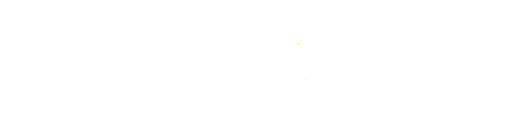

In [160]:
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [123]:
bounding_boxes_list 

tensor([[[ 710.,    0.,  810.,  300.],
         [ 532.,    0.,  632.,  300.],
         [ 545.,    0.,  645.,  300.],
         [ 752.,    0.,  852.,  300.],
         [ 566.,    0.,  666.,  300.],
         [ 648.,    0.,  748.,  300.],
         [ 515.,    0.,  615.,  300.],
         [ 719.,    0.,  819.,  300.],
         [ 532.,    0.,  632.,  300.],
         [ 988.,    0., 1088.,  300.],
         [ 603.,    0.,  703.,  300.],
         [ 445.,    0.,  545.,  300.],
         [ 536.,    0.,  636.,  300.],
         [ 461.,    0.,  561.,  300.],
         [ 557.,    0.,  657.,  300.],
         [1144.,    0., 1244.,  300.],
         [ 557.,    0.,  657.,  300.],
         [ 819.,    0.,  919.,  300.],
         [ 488.,    0.,  588.,  300.],
         [ 445.,    0.,  545.,  300.],
         [ 566.,    0.,  666.,  300.],
         [ 515.,    0.,  615.,  300.],
         [ 553.,    0.,  653.,  300.],
         [ 913.,    0., 1013.,  300.],
         [ 599.,    0.,  699.,  300.],
         [ 922.,    0., 1

In [115]:
len(bounding_boxes_list[0])

40

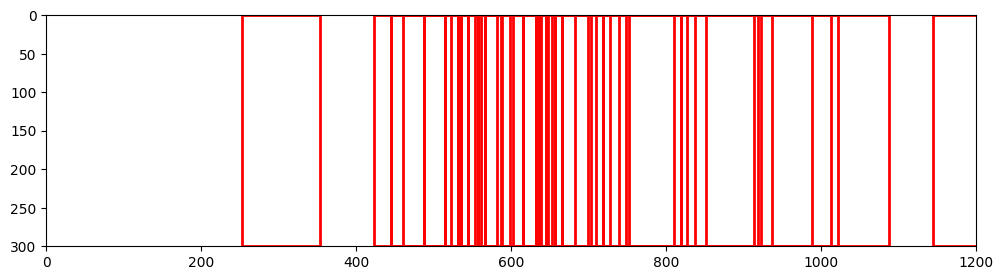

In [124]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

image_width = 1200
image_height = 300

# Create a blank image (white)
fig, ax = plt.subplots(1, figsize=(12, 3))
ax.set_xlim(0, image_width)
ax.set_ylim(0, image_height)
ax.invert_yaxis()  # Invert y-axis to match image coordinate system
#ax.axis('off')

# Draw bounding boxes
for bbox in bounding_boxes_list[0]:
    x1, y1, x2, y2 = bbox
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [127]:
image.shape

(300, 1380, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


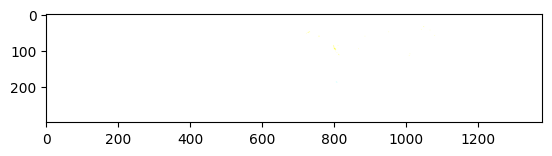

In [128]:
plt.imshow(image)

In [80]:
a = np.array([[1, 2, 3], [4, 5, 6]])
print(a.shape)  # Output: (2, 3)

b = np.expand_dims(a, axis=1)
print(b.shape)  # Output: (2, 1, 3)

a

(2, 3)
(2, 1, 3)


array([[1, 2, 3],
       [4, 5, 6]])

In [79]:
b

array([[[1, 2, 3]],

       [[4, 5, 6]]])

In [94]:
path = r"C:\Users\kagad\OneDrive\Desktop\RADAR_CAM\data\gt\1686210162151891200.png"

In [95]:
img = load_depth(path, data_format= 'CHW')

In [93]:
img.squeeze(0).max()

96.91406

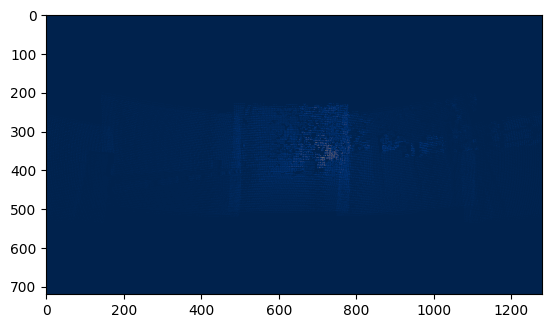

In [90]:
plt.imshow(img.squeeze(0),cmap = "cividis")

In [63]:
img1 = img[img[:,1] < 540]
#img1[:,1] = img1[:,1] - 240
#img1 = img1[img1[:,1] >= 0]

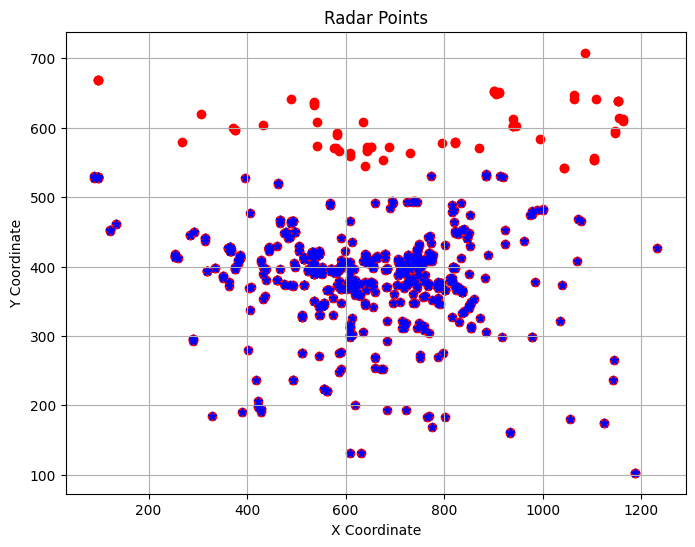

In [64]:
plt.figure(figsize=(8,6))
plt.scatter(img[:,0],img[:,1],c = "red",marker= 'o')
plt.scatter(img1[:,0],img1[:,1],c = "blue",marker= '*')
plt.title('Radar Points')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

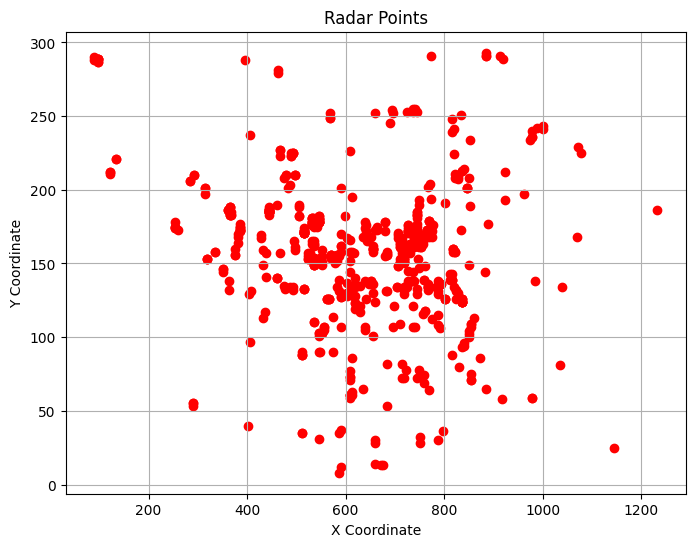

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(img[:,0],img[:,1],c = "red",marker= 'o')
plt.title('Radar Points')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [12]:
len(img[:,2:])

735

In [97]:
img = np.asarray(img,dtype=np.int64)

In [98]:
height, width = img.shape[1:]

In [ ]:
a = np.transpose(img,(1,2,0))

In [65]:
a.shape

(720, 1280, 3)

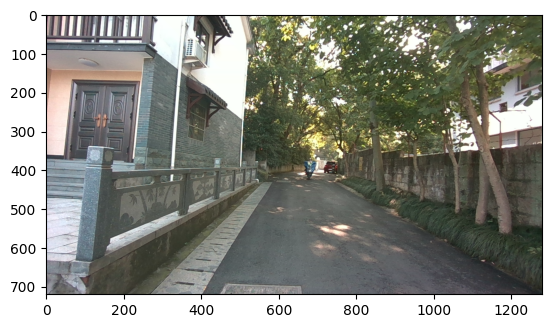

In [66]:
plt.imshow(a)

In [92]:
img = img[:, 720 // 3: 720 // 4 * 3, :]

In [99]:
image = np.pad(
    img,
    pad_width=((0, 0), (0, 0), (128, 1288)),
    mode='edge')

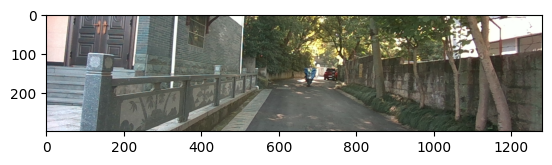

In [100]:
plt.imshow(a)

In [82]:
img.shape

(3, 300, 1280)

In [93]:
a = np.transpose(img,(1,2,0))

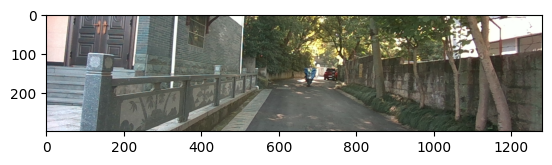

In [81]:
plt.imshow(a)